
참고: https://dacon.io/competitions/official/235736/codeshare/2835?page=1&dtype=recent

건물사용 형태에 따라 전력사용량이 다를 것으로 생각했습니다.
건물 군집별 특징과 군집별 날씨에 대한 사용량에 대해 분석을 했습니다. 


In [156]:
import numpy as np
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings(action='ignore')

# font
plt.rc('font', family='gulim') # For Windows

In [157]:
# 데이터 로드
train = pd.read_csv('./data/train.csv')

In [158]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   num          122400 non-null  int64  
 1   date_time    122400 non-null  object 
 2   전력사용량(kWh)   122400 non-null  float64
 3   기온           122400 non-null  float64
 4   풍속(m/s)      122400 non-null  float64
 5   습도(%)        122400 non-null  float64
 6   강수량(mm|6시간)  122400 non-null  float64
 7   일조(hr|)      122400 non-null  float64
 8   비전기냉방설비운영    122400 non-null  float64
 9   태양광보유        122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


train데이터는 총 122400개이며 결측치가 나오지 않았습니다.

사용하기 쉽도록 컬럼을 영어로 변경합니다.

In [159]:
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']
train = pd.read_csv('./data/train.csv', encoding='utf8', names=train_col, header=0)
train.head(10)

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
5,1,2020-06-01 05,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0
6,1,2020-06-01 06,7978.176,16.7,3.4,90.0,0.1,0.0,0.0,0.0
7,1,2020-06-01 07,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0
8,1,2020-06-01 08,8020.944,17.8,3.3,80.0,0.0,0.3,0.0,0.0
9,1,2020-06-01 09,8083.152,19.3,2.1,73.0,0.0,0.7,0.0,0.0


In [160]:
# date_time에 따른 feature 추가
train['date_time'] = pd.to_datetime(train['date_time'])
train['date'] = train['date_time'].dt.date
train['day'] = train['date_time'].dt.day
train['month'] = train['date_time'].dt.month
train['hour'] = train['date_time'].dt.hour
train['weekday'] = train['date_time'].dt.weekday # 0: 월요일
# train['weekend'] = train['weekday'].isin([5,6]).astype(int) # 주말
train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)
train.head()

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,date,day,month,hour,weekday,dayofyear
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01,1,6,0,0,153
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01,1,6,1,0,153
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,1,6,2,0,153
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,1,6,3,0,153
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01,1,6,4,0,153


### 날씨 흐름과 전력사용량
3개월 전체적인 날씨 흐름과 전력 사용량을 알아봅니다.

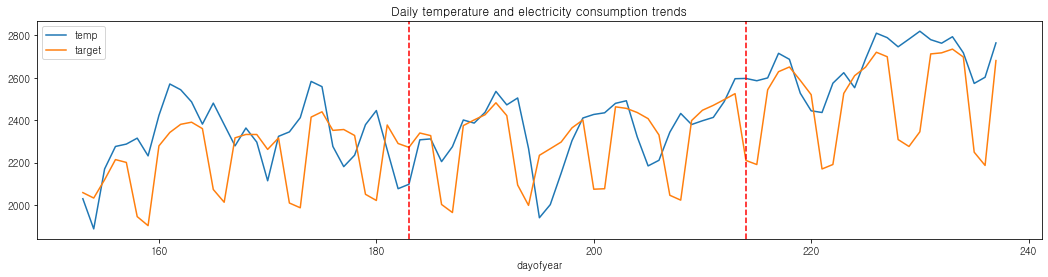

In [161]:
# 일별 기온 및 전력사용량 추이
(train.groupby(['dayofyear'])['temp'].mean()*100).plot(figsize=(18, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
plt.legend(['temp', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.title('Daily temperature and electricity consumption trends')
plt.show()

6월에서 8월로 갈 수록 전력사용량 증가하는것을 알 수 있고, 전력사용량은 기온의 영향을 받는것 같습니다. 중간에 사용량이 떨어지는 부분은 주말에는 사용하지 않는 건물이 있어 떨어지는것 같습니다.

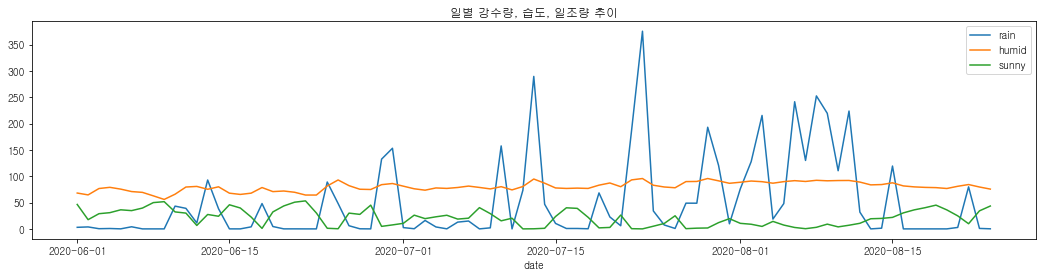

In [162]:
# 일별 강수량, 습도 추이
(train.groupby(['date'])['rain'].mean()*100).plot(figsize=(18, 4))
train.groupby(['date'])['humid'].mean().plot(figsize=(18, 4))
(train.groupby(['date'])['sunny'].mean()*100).plot(figsize=(18, 4))
plt.legend(['rain', 'humid','sunny'])
plt.title('일별 강수량, 습도, 일조량 추이')
plt.show()

- 7~8월은 장마기간입니다.  
검색 결과 6월에서 시작해 8월 초에 끝나는 것을 알 수 있습니다.  
https://news.mt.co.kr/mtview.php?no=2020082110461160385
- 습도는 평균적으로 일정한 편입니다.
- 비가 온 날과 맑은 날은 보통 반대되는 수치를 볼 수 있습니다.

In [163]:
# 일별 일조량
# train.groupby(['date'])['sunny'].sum().plot(kind='bar', figsize=(18, 4))
# plt.title('Daliy Sunlight')
# plt.show()

### 건물별 전력 사용 패턴 분석

1. 군집화를 통한 유형 분류

In [164]:
train_origin = train.copy()

In [165]:
# 정확한 군집화를 위한 스케일링
for i in range(1, 61):
    mean_ = train.loc[train.num == i].target.mean() # 평균
    std_ = train.loc[train.num == i].target.std()   # 표준편차
    train.loc[train.num == i, 'target'] = ((train.loc[train.num == i, 'target']) - mean_) / std_

In [166]:
# 요일에 따른 평균 값 산출
weekday_mean = (
    train.groupby(['num', 'weekday'])['target'].mean()
    .reset_index()
    .pivot('num', 'weekday', 'target')
    .reset_index()
)
weekday_mean.head()

weekday,num,0,1,2,3,4,5,6
0,1,-0.013265,-0.275141,0.065127,0.136859,0.207538,0.004373,-0.124387
1,2,0.219825,0.246954,0.266059,0.304359,0.269986,-0.613713,-0.711788
2,3,-0.001191,0.002234,0.155745,0.198316,0.176369,-0.176871,-0.354502
3,4,-0.156680,-0.169906,-0.071670,0.060515,0.121706,0.223918,0.005172
4,5,0.014861,-0.025999,-0.040268,-0.070623,0.304741,0.074887,-0.258837


In [167]:
# 시간에 따른 평균 값 산출
hour_mean = (
    train.groupby(['num', 'hour'])['target'].mean()
    .reset_index()
    .pivot('num', 'hour', 'target')
    .reset_index()
    .drop('num', axis=1)
)
hour_mean.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.022265,-0.200351,-0.262678,-0.383528,-0.489396,-0.679831,-0.742802,-0.521233,-0.421568,-0.098813,...,0.438781,0.486945,0.490691,0.413908,0.283379,0.294580,0.227571,0.228683,0.234710,0.079624
1,-0.843264,-0.871100,-0.879888,-0.898835,-0.905131,-0.885721,-0.588434,-0.023260,0.693620,0.929527,...,0.927692,0.887512,0.828227,0.656724,0.131663,-0.303718,-0.510565,-0.631740,-0.747649,-0.802314
2,0.068953,0.104412,0.076977,0.155155,0.166295,0.154152,0.269729,0.393576,0.428908,0.068273,...,-0.179592,0.098628,0.158603,0.145217,-0.076369,-0.251865,-0.282285,-0.342865,-0.345398,0.297465
3,-0.738844,-0.803466,-0.838857,-0.869723,-0.901720,-0.915776,-0.912289,-0.883360,-0.188128,0.419805,...,1.145659,1.201668,1.142114,0.907742,0.348254,0.022042,-0.321251,-0.510391,-0.682189,-0.649852
4,0.581476,0.466763,0.427613,0.399576,0.372876,-0.726423,-1.259373,-1.440235,-0.757198,-0.334699,...,-0.168711,-0.120386,-0.313461,-0.438549,-0.915961,0.234951,0.996338,0.953813,0.837413,0.710313


In [168]:
# 요일별, 시간별 평균 전력 사용량 테이블 구축
cl_df = pd.concat([weekday_mean, hour_mean], axis=1)
cl_df.head()

,num,0,1,2,3,4,5,6,0,1,...,14,15,16,17,18,19,20,21,22,23
0,1,-0.013265,-0.275141,0.065127,0.136859,0.207538,0.004373,-0.124387,-0.022265,-0.200351,...,0.438781,0.486945,0.490691,0.413908,0.283379,0.294580,0.227571,0.228683,0.234710,0.079624
1,2,0.219825,0.246954,0.266059,0.304359,0.269986,-0.613713,-0.711788,-0.843264,-0.871100,...,0.927692,0.887512,0.828227,0.656724,0.131663,-0.303718,-0.510565,-0.631740,-0.747649,-0.802314
2,3,-0.001191,0.002234,0.155745,0.198316,0.176369,-0.176871,-0.354502,0.068953,0.104412,...,-0.179592,0.098628,0.158603,0.145217,-0.076369,-0.251865,-0.282285,-0.342865,-0.345398,0.297465
3,4,-0.156680,-0.169906,-0.071670,0.060515,0.121706,0.223918,0.005172,-0.738844,-0.803466,...,1.145659,1.201668,1.142114,0.907742,0.348254,0.022042,-0.321251,-0.510391,-0.682189,-0.649852
4,5,0.014861,-0.025999,-0.040268,-0.070623,0.304741,0.074887,-0.258837,0.581476,0.466763,...,-0.168711,-0.120386,-0.313461,-0.438549,-0.915961,0.234951,0.996338,0.953813,0.837413,0.710313


In [169]:
# 보기 편하게 컬럼 이름 지정
columns = (
    ['num']
    + ['mon','tue','wed','thu','fri','sat','sun'] 
    + [str(i)+'h' for i in range(24)]
)

cl_df.columns = columns
cl_df.head()

,num,mon,tue,wed,thu,fri,sat,sun,0h,1h,...,14h,15h,16h,17h,18h,19h,20h,21h,22h,23h
0,1,-0.013265,-0.275141,0.065127,0.136859,0.207538,0.004373,-0.124387,-0.022265,-0.200351,...,0.438781,0.486945,0.490691,0.413908,0.283379,0.294580,0.227571,0.228683,0.234710,0.079624
1,2,0.219825,0.246954,0.266059,0.304359,0.269986,-0.613713,-0.711788,-0.843264,-0.871100,...,0.927692,0.887512,0.828227,0.656724,0.131663,-0.303718,-0.510565,-0.631740,-0.747649,-0.802314
2,3,-0.001191,0.002234,0.155745,0.198316,0.176369,-0.176871,-0.354502,0.068953,0.104412,...,-0.179592,0.098628,0.158603,0.145217,-0.076369,-0.251865,-0.282285,-0.342865,-0.345398,0.297465
3,4,-0.156680,-0.169906,-0.071670,0.060515,0.121706,0.223918,0.005172,-0.738844,-0.803466,...,1.145659,1.201668,1.142114,0.907742,0.348254,0.022042,-0.321251,-0.510391,-0.682189,-0.649852
4,5,0.014861,-0.025999,-0.040268,-0.070623,0.304741,0.074887,-0.258837,0.581476,0.466763,...,-0.168711,-0.120386,-0.313461,-0.438549,-0.915961,0.234951,0.996338,0.953813,0.837413,0.710313


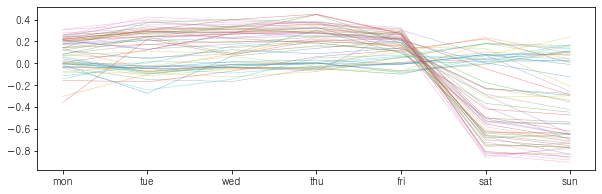

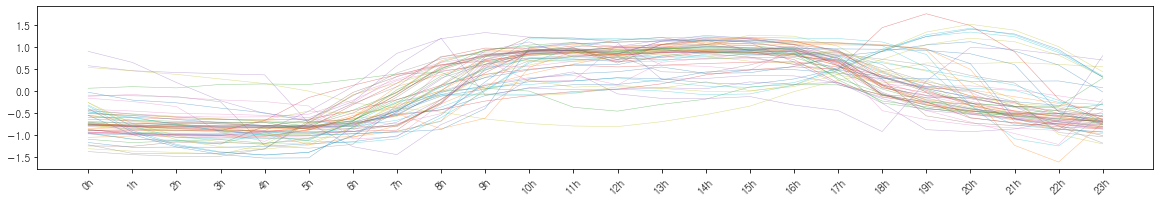

In [170]:
# 시각화를 통한 사용량 확인
fig = plt.figure(figsize = (10,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
    
fig = plt.figure(figsize = (20,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 8:32], alpha = 0.5, linewidth = 0.5)
    plt.xticks(rotation=45)

60개 건물의 일주일, 24시간 사용량을 확인할 수 있다.

2. 건물 군집 유형 비교 

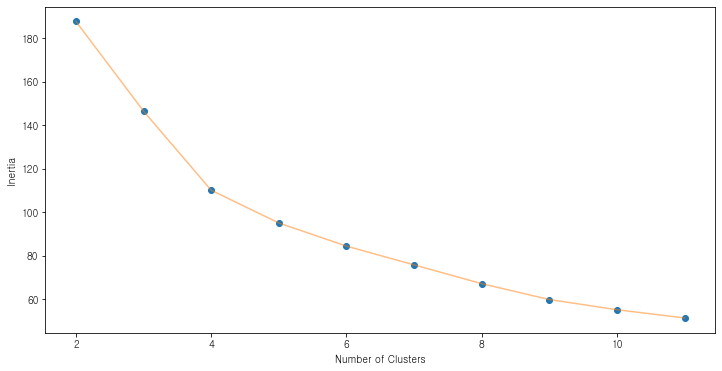

In [171]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], cl_df.iloc[:,1:])

엘보우 포인트: 4  
4개의 건물유형으로 나눠볼 수 있다.

In [172]:
# 엘보우 포인트를 통해 kmeans 클러스터링
model = KMeans(n_clusters = 4, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [173]:
# 값 할당
cl_df['km_cluster'] = pred

# 기존 train set과 merge
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

In [174]:
# 군집별 분석을 위한 4개의 데이터셋 할당
km_0 = list(train_cl.loc[train_cl.km_cluster == 0].num.unique())
km_1 = list(train_cl.loc[train_cl.km_cluster == 1].num.unique())
km_2 = list(train_cl.loc[train_cl.km_cluster == 2].num.unique())
km_3 = list(train_cl.loc[train_cl.km_cluster == 3].num.unique())

In [175]:
# 군집별 건물의 num가 있는것 확인 가능
km_0

[19, 20, 21, 34, 49, 50, 51]

In [176]:
# 각 건물의 데이터 개수
(train_cl['num']==2).count()

122400

In [177]:
train_cl.groupby(['km_cluster'])['num'].count().to_frame()/2040 

,num
km_cluster,
0,7.0
1,33.0
2,5.0
3,15.0


건물 수(비율) : 1번 > 3번 > 0번 > 2번  

유형별로 시간대별 전기사용량을 알아봅니다.

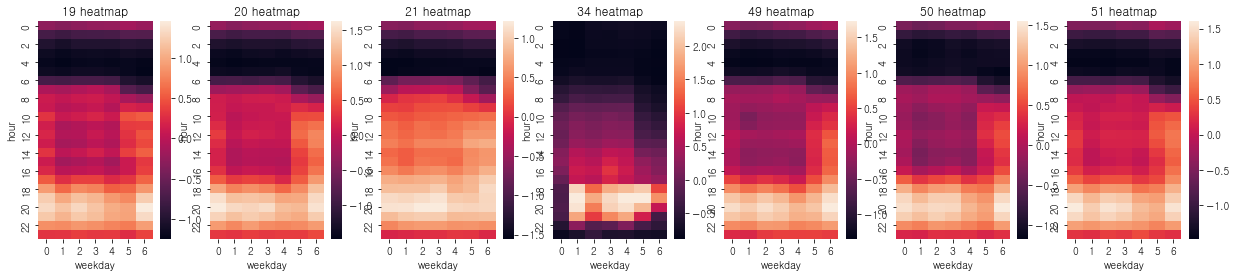

In [178]:
# 0 번 (km_0)
fig = plt.figure(figsize=(21, np.ceil(len(km_0)/7)*4))
for i, n in enumerate(km_0):
    plt.subplot(int(np.ceil(len(km_0)/7)), 7, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

- 일주일 운영  
- 주말과 밤에 전력사용량이 집중 
- 평일보다는 주말에 사용량 증가  

상업시설이나 술집, 식당이 모여있는 번화가형 건물로 추정됩니다.

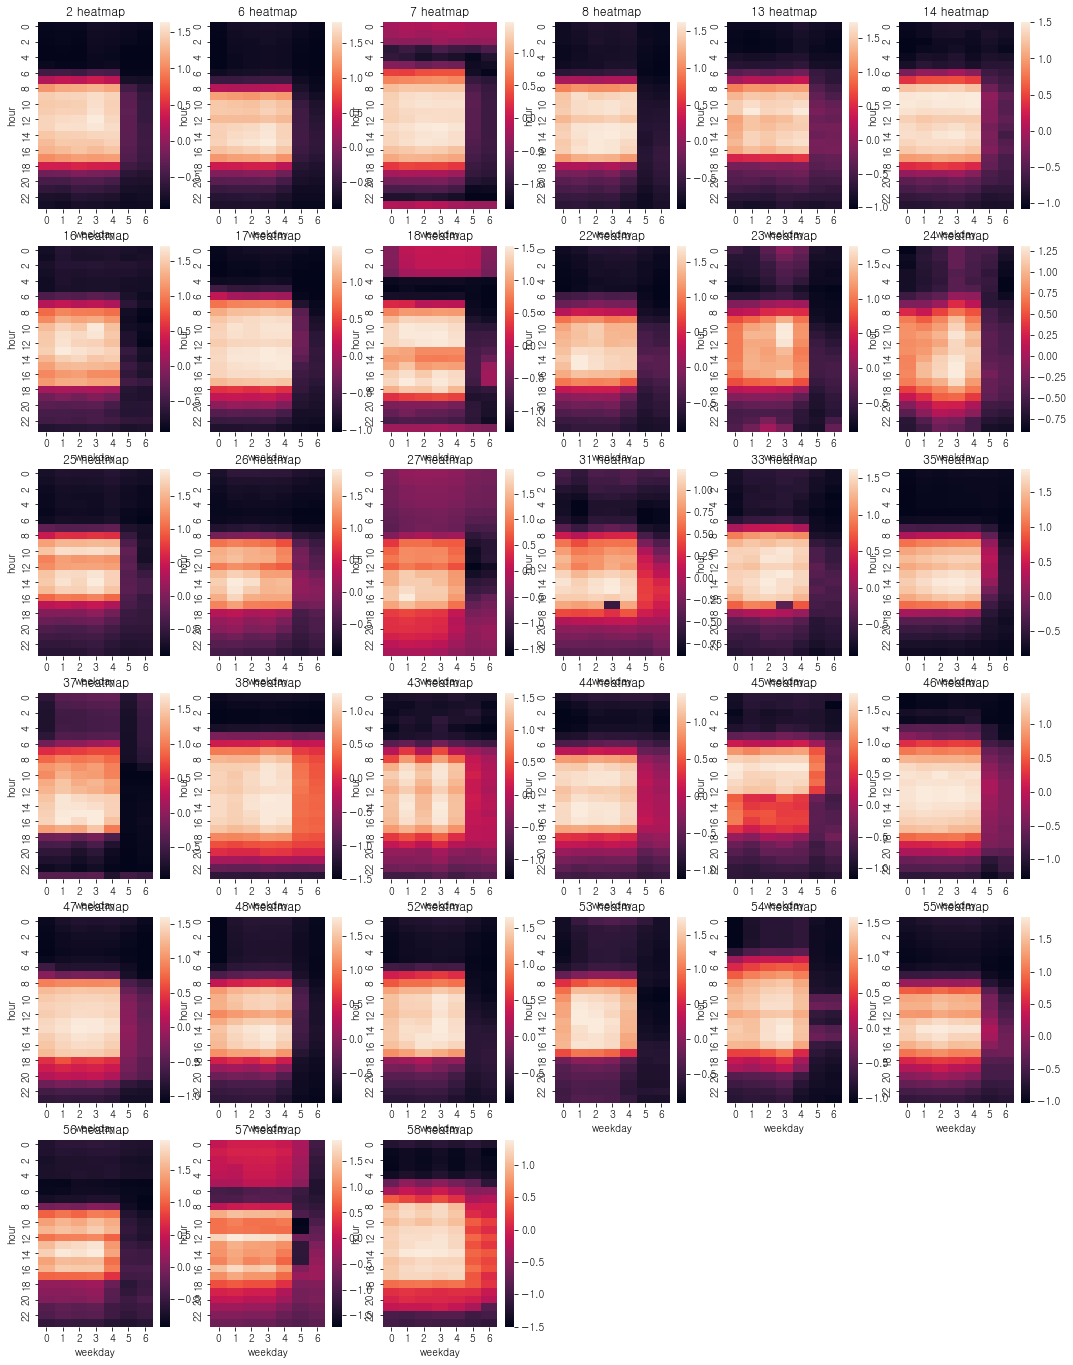

In [179]:
# 1 번 (km_1)
fig = plt.figure(figsize=(18, np.ceil(len(km_1)/6)*4))
for i, n in enumerate(km_1):
    plt.subplot(int(np.ceil(len(km_1)/6)), 6, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

- 전력사용량이 평일 8~18시(업무시간)에 집중되어 있음  
- 주로 평일에만 운영  

사무실, 상업시설이 공존하는 오피스형 건물로 추정됩니다.

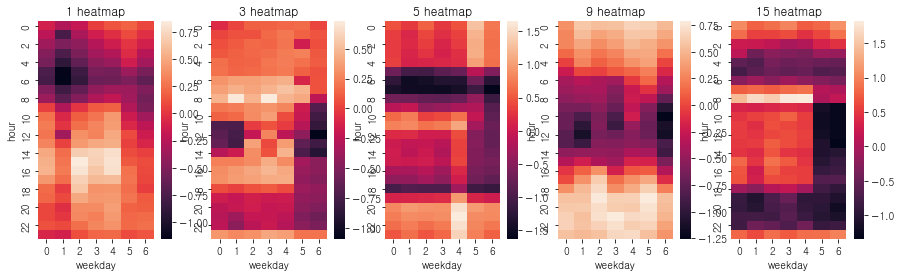

In [180]:
# 2 번 (km_2)
fig = plt.figure(figsize=(15, np.ceil(len(km_2)/5)*4))
for i, n in enumerate(km_2):
    plt.subplot(int(np.ceil(len(km_2)/7)), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

- 일주일, 24시간 운영  
-  다양한 패턴의 전력사용량을 보임

24시간 돌아가는 공장이나 병원과 같은 곳이 아닐까 예상됩니다.

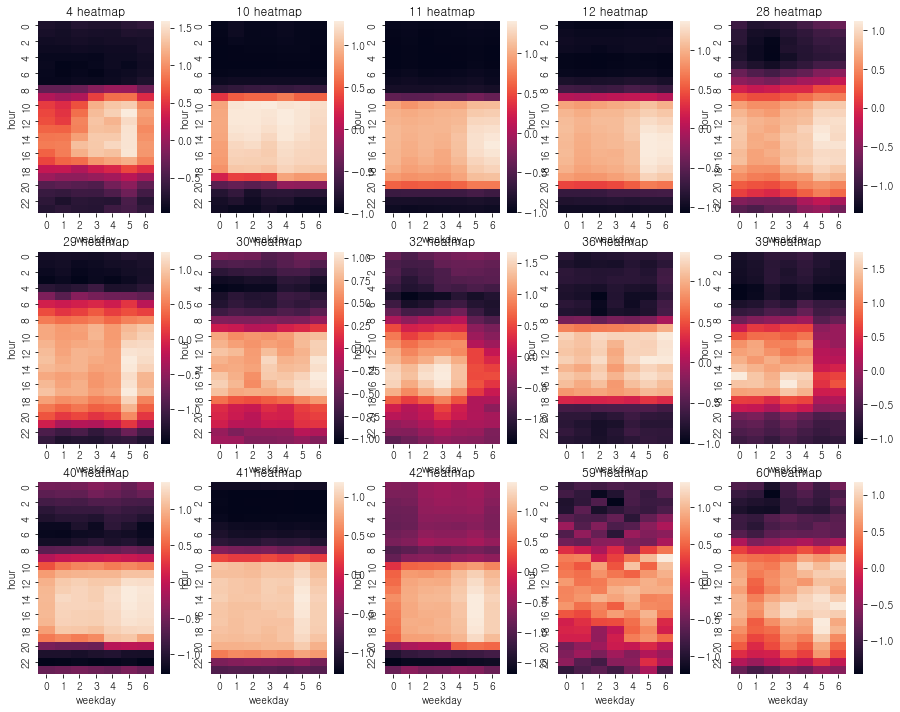

In [181]:
# 3 번 (km_3)
fig = plt.figure(figsize=(15, np.ceil(len(km_3)/5)*4))
for i, n in enumerate(km_3):
    plt.subplot(int(np.ceil(len(km_3)/7)), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

- 일주일 운영, 전력사용량이 9~20시에 집중
- 번화가유형과 비슷하나 운영시간 전체적으로 사용량이 비슷함

일반적 상업시설이 존재하는 상가형 건물로 추정됩니다.

3. 군집별 시간에 대한 분석

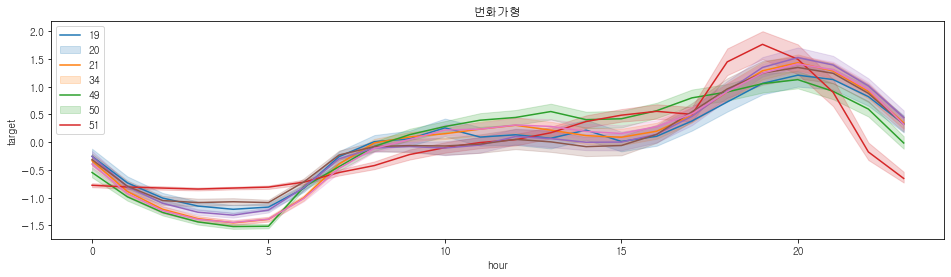

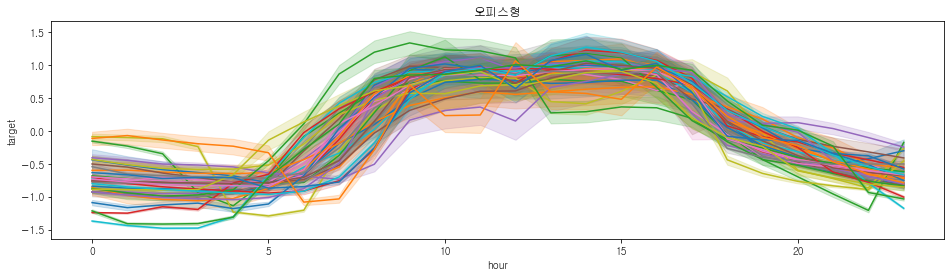

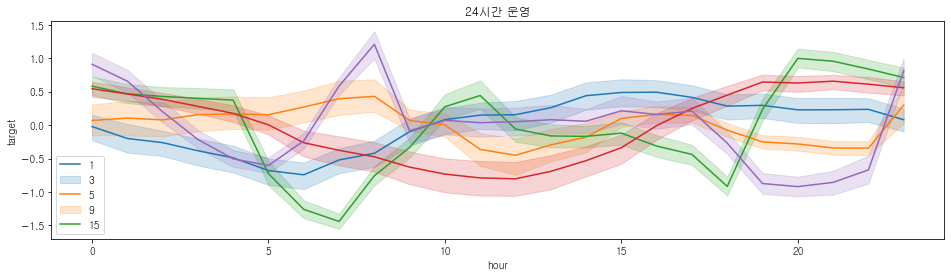

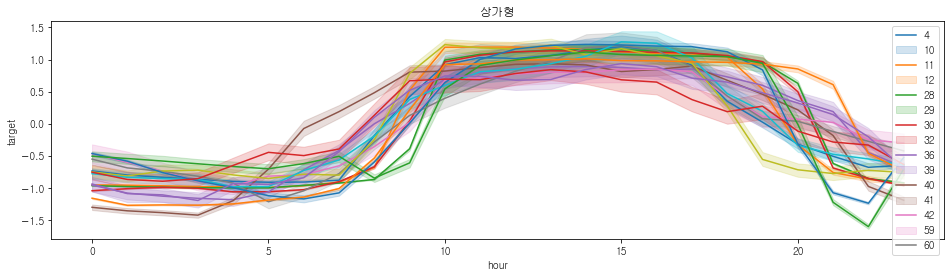

In [182]:
# 번화가형
fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 0].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 0) & (train_cl.num == i)], x='hour', y='target')
plt.title('번화가형')
plt.legend(list(train_cl.loc[train_cl.km_cluster == 0].num.unique()))

# 오피스형
fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 1].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 1) & (train_cl.num == i)], x='hour', y='target')
plt.title('오피스형')

# 병원, 공장형
fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 2].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 2) & (train_cl.num == i)], x='hour', y='target')
plt.title('24시간 운영')
plt.legend(list(train_cl.loc[train_cl.km_cluster == 2].num.unique()))

# 상가형
fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 3].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 3) & (train_cl.num == i)], x='hour', y='target')
plt.title('상가형')
plt.legend(list(train_cl.loc[train_cl.km_cluster == 3].num.unique()))

4. 군집별 날씨에 대한 사용량 분석

In [183]:
train_cl['target_org'] = train_origin['target']

def plot_target_avg_of_cluster(cluster_num):
    avg_date = train_cl[train_cl['km_cluster']==cluster_num].groupby(['date']).mean()
    df = avg_date[['temp', 'wind', 'humid', 'rain', 'sunny','target_org']]
    normalized_df = (df - df.mean()) / df.std() + 2

    columns = ['temp', 'wind', 'humid', 'rain', 'sunny']
    for c in columns:
        fig = plt.figure(figsize = (25,3))
        plt.plot(normalized_df.index, normalized_df.target_org, color="red")
        plt.bar(normalized_df.index, getattr(normalized_df, c))
        plt.ylabel(c)
        plt.show()

In [184]:
# km_cluster = 0 인 경우로 정규화된 데이터 출력 예시
avg_date = train_cl[train_cl['km_cluster']==0].groupby(['date']).mean()
df = avg_date[['temp', 'wind', 'humid', 'rain', 'sunny','target_org']]
normalized_df = (df - df.mean()) / df.std() + 2
normalized_df

,temp,wind,humid,rain,sunny,target_org
date,,,,,,
2020-06-01,0.086631,3.109435,0.987564,1.457591,3.663576,0.561658
2020-06-02,-0.694814,1.919913,0.674916,1.479206,1.667502,0.788386
2020-06-03,0.700666,2.530581,1.752129,1.423625,2.947794,0.784464
2020-06-04,0.910807,2.681890,2.243838,1.426713,2.379595,0.888424
2020-06-05,1.199093,1.258810,1.618543,1.420537,3.194997,0.892167
...,...,...,...,...,...,...
2020-08-20,3.851325,1.063272,1.740192,1.420537,2.224632,4.310003
2020-08-21,3.160316,0.994989,2.302389,1.497734,1.711777,3.759563
2020-08-22,2.381212,1.620399,2.617310,2.735962,1.372334,3.013330


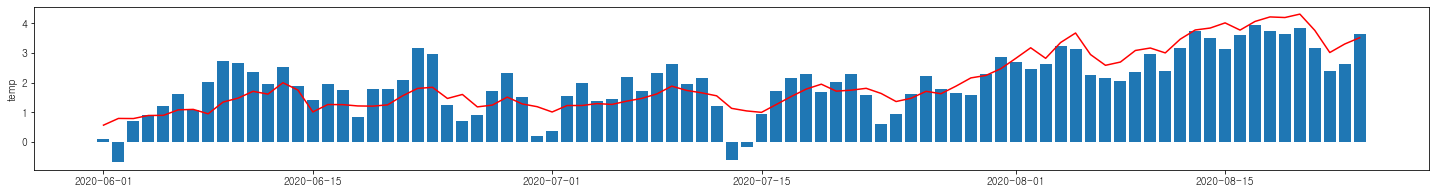

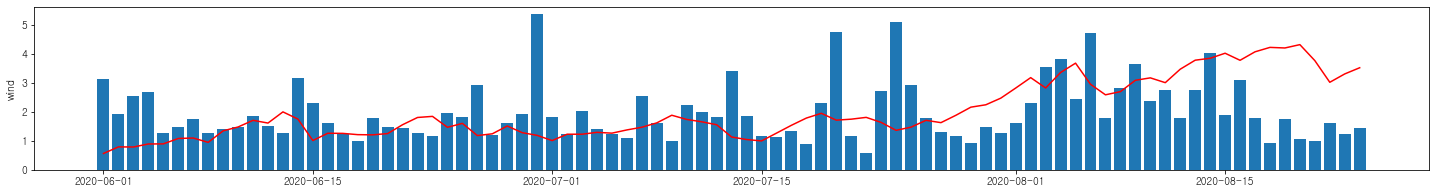

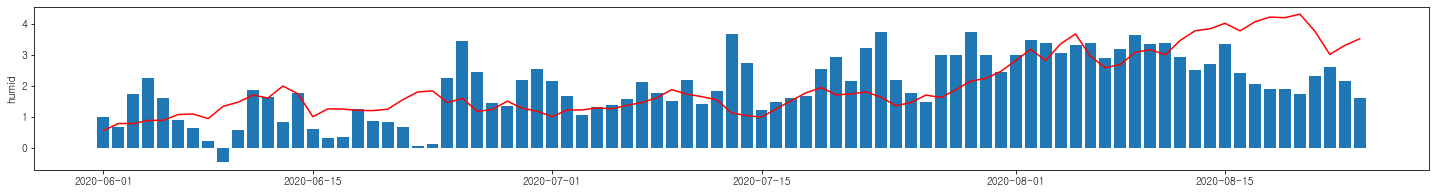

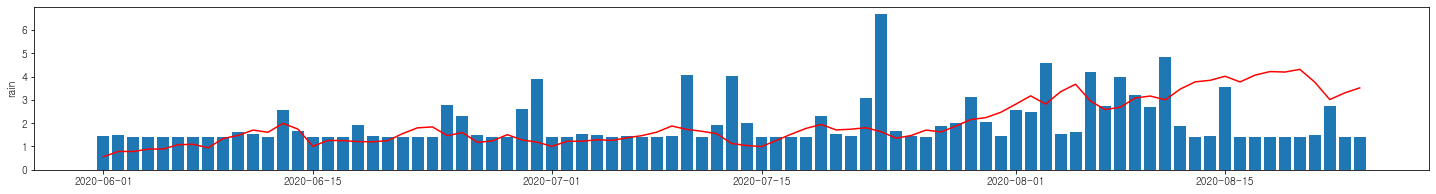

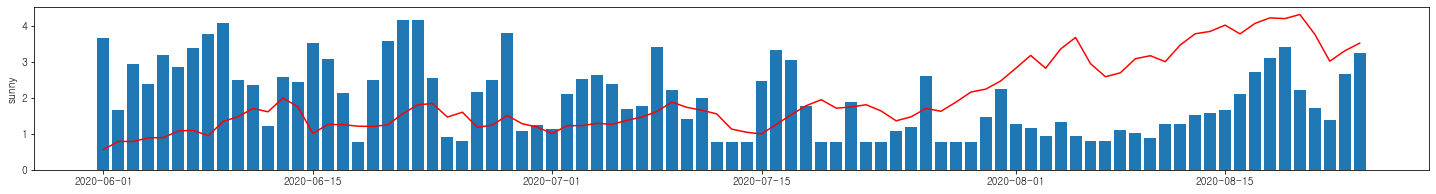

In [185]:
# 번화가형
plot_target_avg_of_cluster(0)

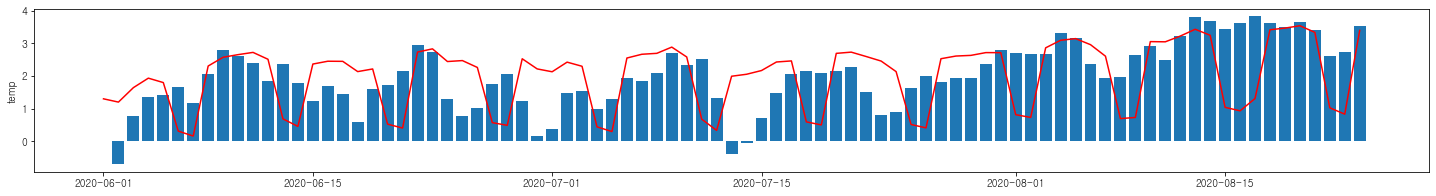

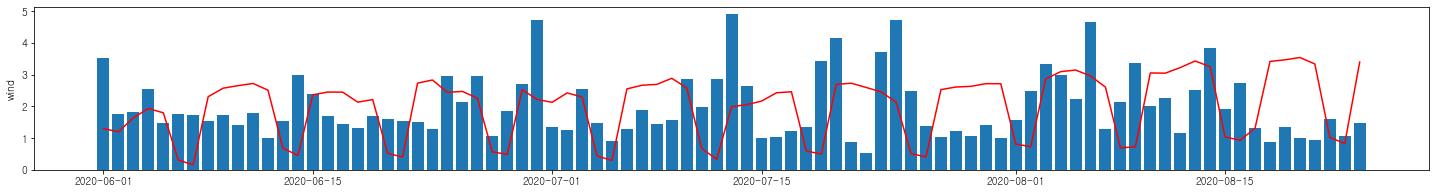

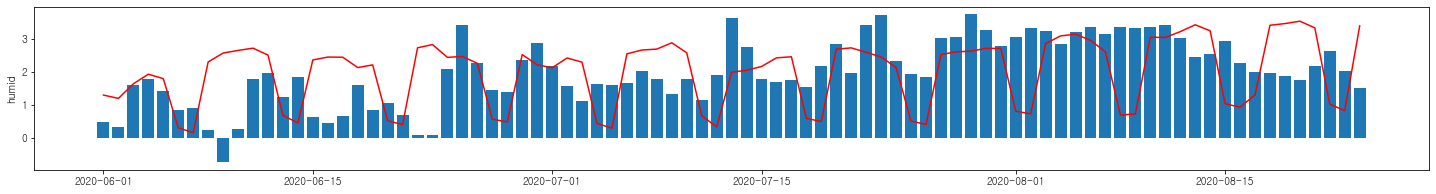

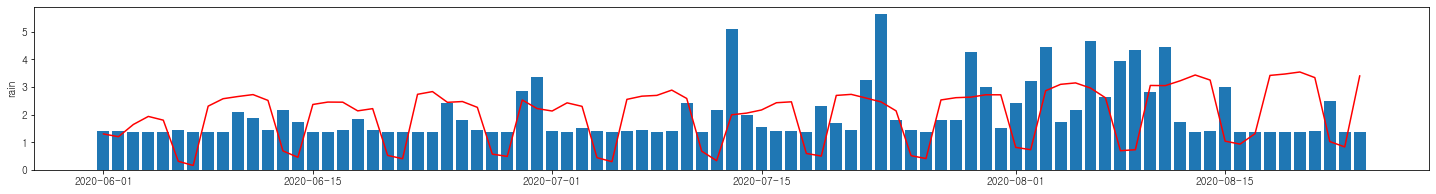

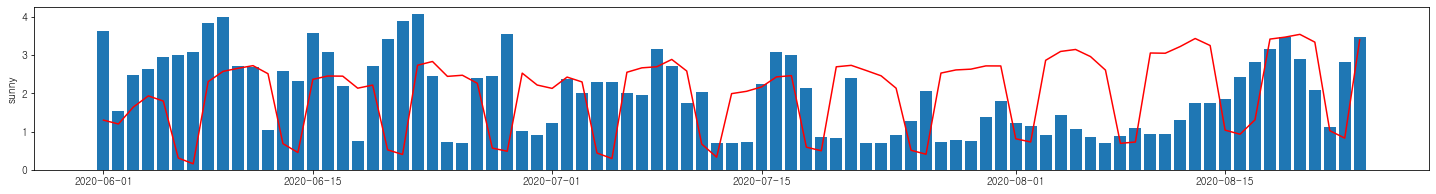

In [186]:
# 오피스형
plot_target_avg_of_cluster(1)

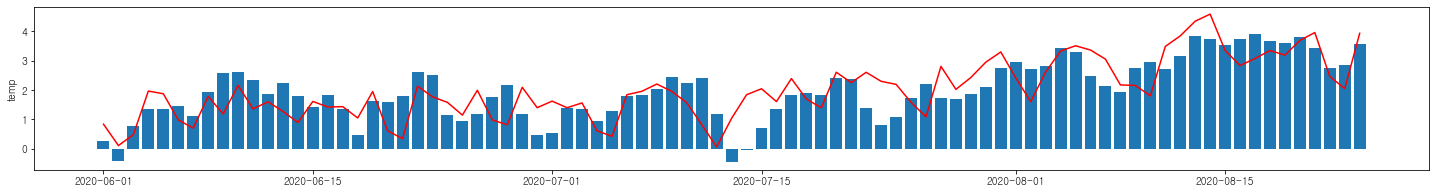

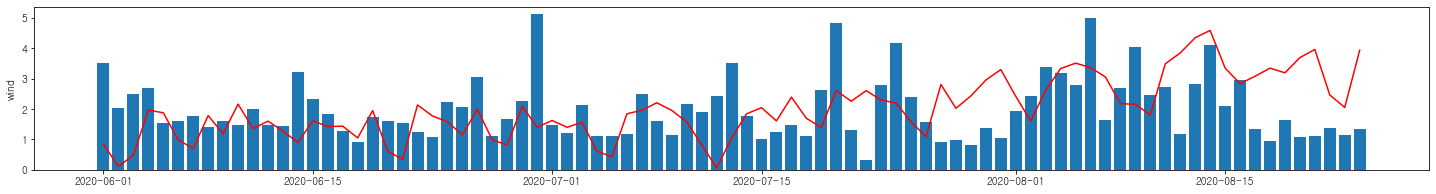

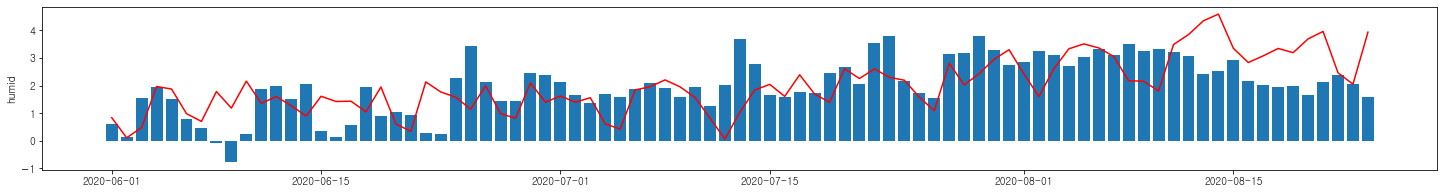

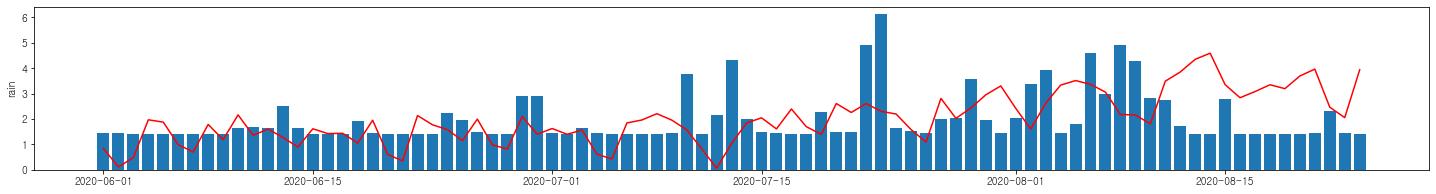

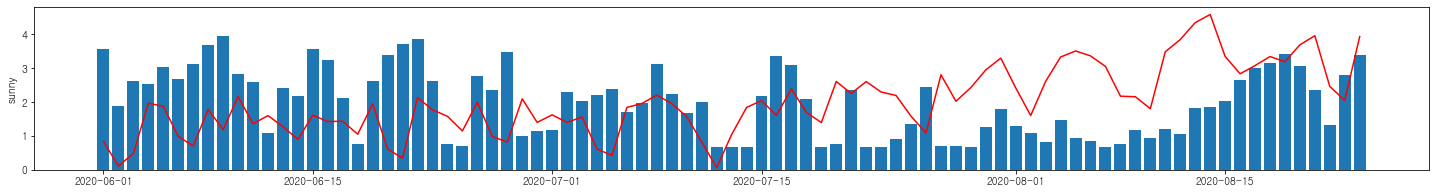

In [187]:
# 24시간 운영
plot_target_avg_of_cluster(2)

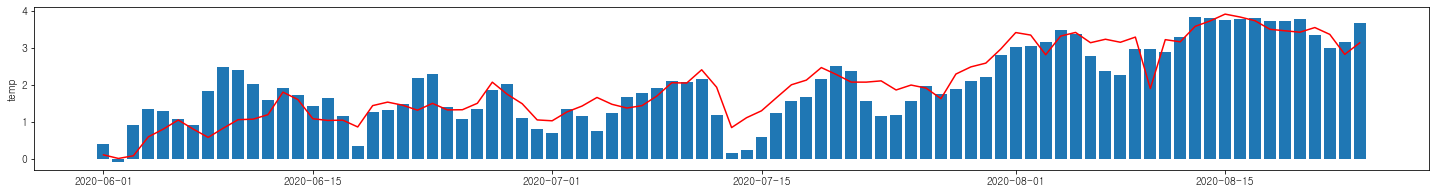

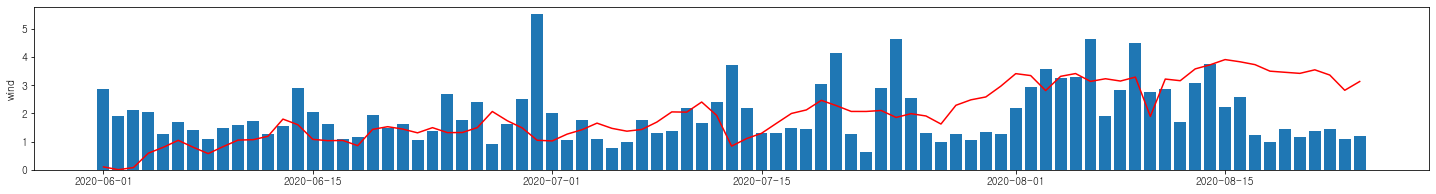

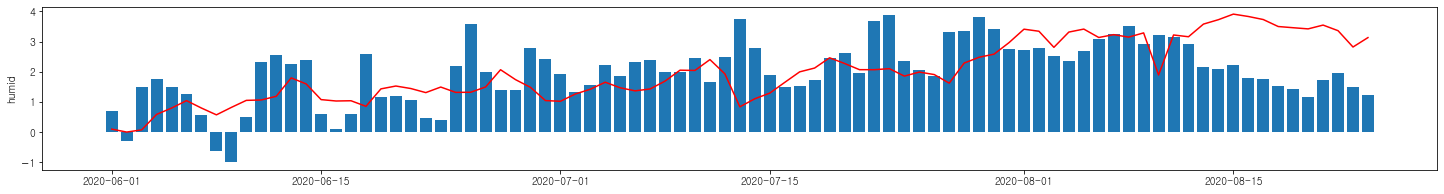

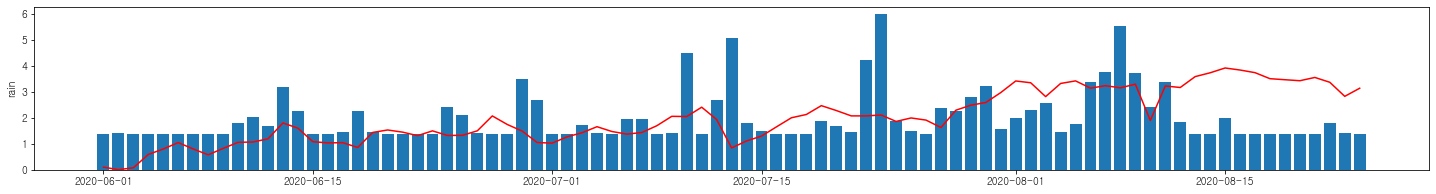

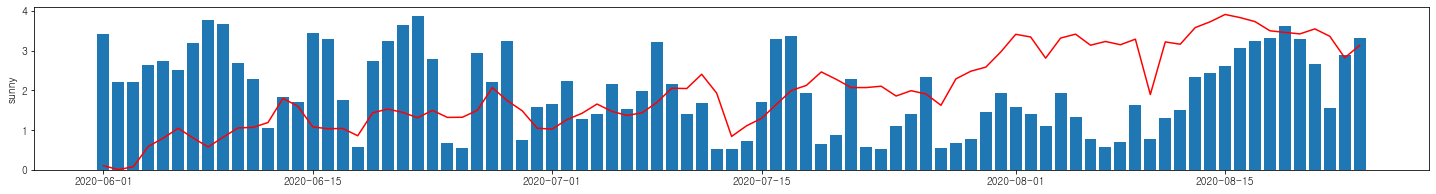

In [188]:
# 상가형
plot_target_avg_of_cluster(3)

**2. 기상 변수에 대한 상관 분석**
1. 상관계수 구하기

In [189]:
# 피어슨 상관계수 사용
from scipy.stats import pearsonr

In [190]:
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)

corrs_temp = train_cl.groupby(['km_cluster', 'num'])['target'].mean().to_frame()
temp = train_cl.groupby(['num'])['cooler', 'solar'].max()

In [191]:
# 건물별로, 기상요인별로 전력소비량과의 상관계수를 계산해줍니다.
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['temp_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].humid,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['humid_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].sunny,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['sunny_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].wind,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['wind_corr'] = corrs

In [192]:
corrs_cl_temp = pd.merge(corrs_temp, temp, how='left', on='num').set_index(corrs_temp.index).round(2)
corrs_cl_temp.head(10)

target  cooler  solar  temp_corr  humid_corr  sunny_corr  \
km_cluster num                                                             
0          19      0.0     0.0    0.0       0.60        0.03        0.17   
           20     -0.0     0.0    0.0       0.53       -0.12        0.12   
           21      0.0     0.0    1.0       0.62       -0.14        0.17   
           34     -0.0     1.0    1.0       0.46       -0.16        0.10   
           49      0.0     0.0    0.0       0.47       -0.05        0.04   
           50      0.0     0.0    0.0       0.54        0.05        0.13   
           51      0.0     0.0    1.0       0.50       -0.06        0.09   
1          2       0.0     1.0    0.0       0.45       -0.16        0.47   
           6       0.0     0.0    0.0       0.49       -0.41        0.42   
           7       0.0     1.0    0.0       0.24       -0.11        0.23   

                wind_corr  
km_cluster num             
0          19        0.23  
           20        0.19  
           21        0.23  
           34        0.22  
           49        0.17  
           50        0.19  
           51        0.21  
1          2         0.20  
           6         0.34  
           7         0.15

In [200]:
corrs_temp_temp = (corrs_cl_temp[['temp_corr', 'humid_corr', 'wind_corr']]
                   .reset_index()
                   .sort_values(by=['temp_corr', 'humid_corr', 'wind_corr'], ascending=True)
                  .set_index(['num'], drop=False))
corrs_temp_temp.head(10)

,km_cluster,num,temp_corr,humid_corr,wind_corr
num,,,,,
9,2,9,-0.16,0.40,-0.13
15,2,15,0.16,0.18,-0.05
3,2,3,0.23,0.16,-0.04
7,1,7,0.24,-0.11,0.15
5,2,5,0.27,-0.06,0.07
37,1,37,0.30,-0.19,0.19
33,1,33,0.32,-0.35,0.16
17,1,17,0.33,-0.21,0.20
48,1,48,0.34,-0.32,0.11


In [197]:
def heatmap_target_avg_of_num(km_num,train_origin):
    km_target = []
    for num in km_num:
        km_target.append(train_origin[train_origin['num']==num]['target'].mean())

    df = pd.DataFrame()
    df.index = km_num
    df['targert_avg'] = km_target

    plt.figure(figsize=(22, 1))
    plt.title('평균 전력사용량')
    sns.heatmap(df.transpose(), annot=True, linewidths=.5, vmin=min(km_target), vmax=max(km_target))
    plt.show()

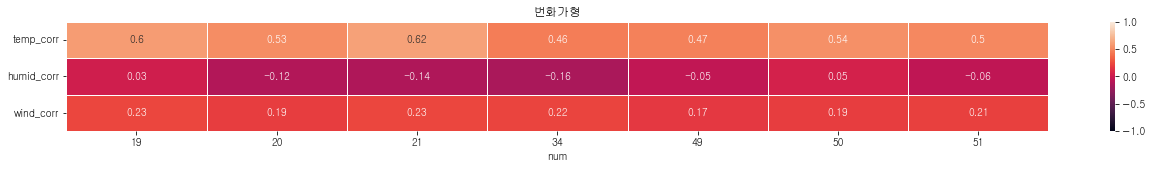

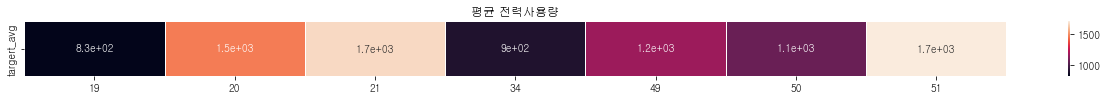

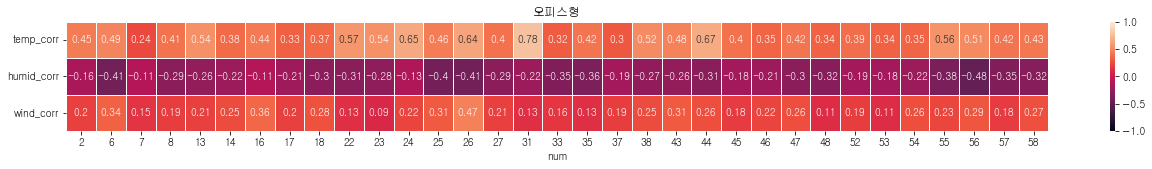

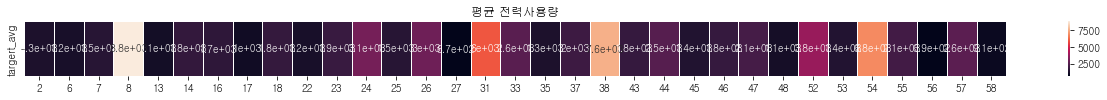

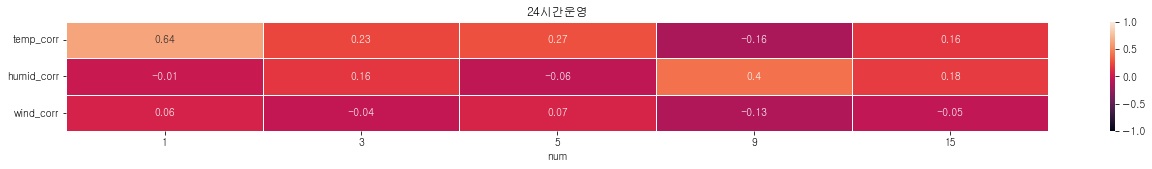

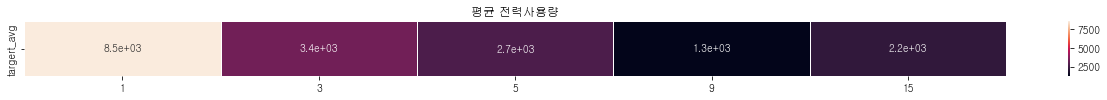

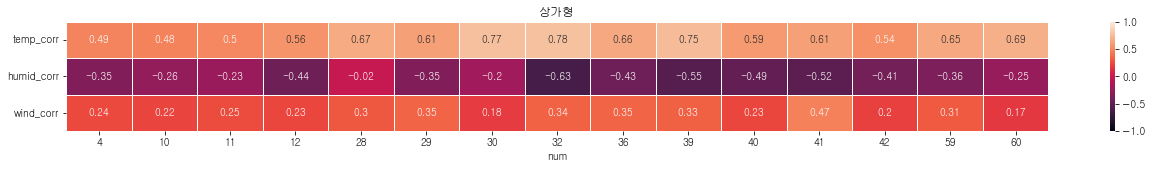

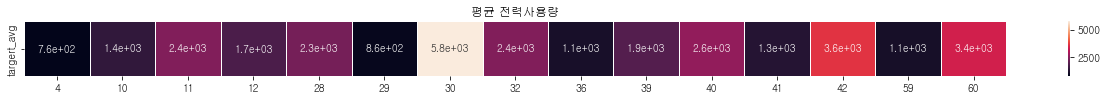

In [199]:
# 번화가형
plt.figure(figsize=(22, 2))
plt.title('번화가형')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0][['temp_corr','humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

heatmap_target_avg_of_num(km_0,train_origin)

# 오피스형
plt.figure(figsize=(22, 2))
plt.title('오피스형')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1][['temp_corr', 'humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

heatmap_target_avg_of_num(km_1,train_origin)

# 24시간형
plt.figure(figsize=(22, 2))
plt.title('24시간운영')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2][['temp_corr', 'humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

heatmap_target_avg_of_num(km_2,train_origin)

# 상가형
plt.figure(figsize=(22, 2))
plt.title('상가형')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3][['temp_corr', 'humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

heatmap_target_avg_of_num(km_3,train_origin)

- 상관관계 해석 https://gomguard.tistory.com/173  
- 기상변화에 얼마나 민감한지에 대한 내용입니다.
- 기상의 영향을 많이 받는 건물이라면, 기온에 대한 양의 상관관계, 습도에 대한 음의 상관관계를 띄운다고 볼 수 있습니다.
- 평균 전력사용량은 사용량을 비교하면서 볼 수 있도록 추가했습니다.